In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, countDistinct, count
from pyspark.sql.window import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
import pandas as pd
import matplotlib.pyplot as plt
import time

In [34]:
from pyspark.sql.functions import mean
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline 

In [2]:
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "15g").getOrCreate()

In [3]:
spark

In [5]:
loans_df = spark.read.csv("Loan_Dataset/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



In [6]:
loans_df.select(["LoanIdFormat","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+------------+------+-------------------+--------------------+-----+
|LoanIdFormat|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+------------+------+-------------------+--------------------+-----+
|           1|   500|                 10|              Weekly|    3|
|           1|   700|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   900|                 10|              Weekly|    3|
|           1|  1000|                 10|              Weekly|    3|
|           1|  1000|                 10|              Weekly|    3|
+------------+------+-------------------+--------------------+-----+
only showing top 10 rows



In [7]:
loans_df.select(["userId","LoanIdFormat","count","Amount","Total_Repayments__c","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|summary|            userId|      LoanIdFormat|             count|           Amount|Total_Repayments__c|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|  count|            559151|            559151|            559151|           559151|             559151|                    559151|              559151|
|   mean|24735.774815747445| 4.527168868516734|1.6699120631099649|823.7755990778877| 7.0393507299459355|        11.901447015206983|   11.85676856519974|
| stddev|15283.929730968575|2.7984778294163046|0.8954014280676444|766.2637755312196| 3.9631196080149786|         8.154409123854771|   8.273339043377455|
|    min|                 1|                 1|                 0|              10

In [8]:
loans_df.show(vertical=True)

-RECORD 0------------------------------------------
 Id                         | 0062x00000DsEQcAAN   
 AccountID                  | 0010K00001ayVHPQA2   
 Number_Of_Loans_Granted__c | 27                   
 Num_Of_Loans_Paid__c       | 27                   
 Purpose_of_Loan__c         | Furniture or Appl... 
 Total_Repayments__c        | 10                   
 Amount                     | 500                  
 Term_in_Weeks__c           | 10.143               
 Payment_Frequency__c       | Weekly               
 StageName                  | Loan Paid            
 Applicant Age              | 55                   
 summary_income             | 2166.67              
 summary_income_cv          | 5750.7               
 city                       | Jimboomba            
 state                      | QLD                  
 Country                    | Australia            
 userId                     | 1                    
 loanId                     | 385865               
 count      

In [9]:
hist_data  = loans_df.toPandas()

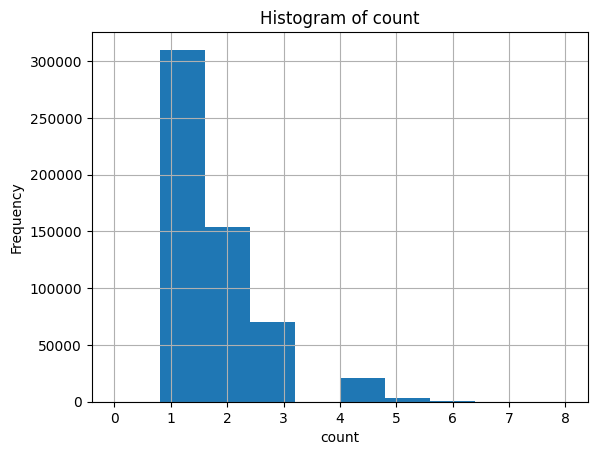

In [10]:
hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

In [11]:
# Count the number of unique items
num_unique_loan_id_format = loans_df.select('LoanIdFormat').distinct().count()
print(f"Number of unique loanId_format: {num_unique_loan_id_format}")

# Count the number of unique users
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format: 20
Number of unique Loan Id: 407389


In [12]:
# Count the number of unique items
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

# Count the number of unique users
# tmp = ratings_df.select('movieId').distinct().count()
# print(f"Number of unique movies: {tmp}")

Number of unique users: 59158


In [13]:
# distinct values of the rating
loans_df.select("count").distinct().show()

+-----+
|count|
+-----+
|    1|
|    6|
|    3|
|    5|
|    4|
|    8|
|    7|
|    2|
|    0|
+-----+



========================================================================================================

Converting the dataset into train test and validation split.

In [15]:
loans_df.select(["LoanIdFormat","count","Amount"]).show(10)

+------------+-----+------+
|LoanIdFormat|count|Amount|
+------------+-----+------+
|           1|    3|   500|
|           1|    3|   700|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   900|
|           1|    3|  1000|
|           1|    3|  1000|
+------------+-----+------+
only showing top 10 rows



In [16]:
train, validation = loans_df.randomSplit([0.8, 0.2])
# train, validation, test = loans_df.randomSplit([0.8, 0.1, 0.1])
# # cache data
train.cache()
validation.cache()
# test.cache()

DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: int, summary_income: double, summary_income_cv: double, city: string, state: string, Country: string, userId: int, loanId: int, count: int, LoanIdFormat: int]

In [17]:
validation.select(["userId","loanId","LoanIdFormat","count","Amount","Total_Repayments__c"]).show()

+------+------+------------+-----+------+-------------------+
|userId|loanId|LoanIdFormat|count|Amount|Total_Repayments__c|
+------+------+------------+-----+------+-------------------+
|   130|     6|           1|    3|   400|                 10|
| 25117|    33|           1|    3|   650|                 10|
| 23722|    52|           1|    1|   800|                 10|
| 25097|    90|           1|    2|   200|                 10|
|   186|    99|           1|    1|   350|                 10|
| 25245|   190|           1|    1|   850|                 10|
|    76|   231|           1|    1|   400|                 10|
| 25043|   253|           1|    2|   400|                 10|
| 24094|   254|           1|    1|  1000|                 10|
| 24945|   286|           1|    1|   500|                 10|
| 24975|   289|           1|    2|   200|                 10|
| 24267|   291|           1|    3|   200|                 10|
| 25279|   323|           1|    1|   500|                 10|
| 23319|

In [18]:
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



In [19]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # Train the model using the training data
            als_model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='userId', itemCol='LoanIdFormat', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)
            model = als_model.fit(train_data)
            
            # Generate predictions on the test data
            predictions = model.transform(validation_data)
            predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))
            
            evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
            error = evaluator.evaluate(predictions)
            
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [20]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 20, 40, 60]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.020444812351840813
8 latent factors and regularization = 0.01: validation RMSE is 0.025620431301841107
8 latent factors and regularization = 0.05: validation RMSE is 0.08053144305623325
8 latent factors and regularization = 0.1: validation RMSE is 0.10213915589542055
8 latent factors and regularization = 0.2: validation RMSE is 0.19814911852343314
10 latent factors and regularization = 0.001: validation RMSE is 0.03799510096152451
10 latent factors and regularization = 0.01: validation RMSE is 0.055210625986972184
10 latent factors and regularization = 0.05: validation RMSE is 0.07669887253088171
10 latent factors and regularization = 0.1: validation RMSE is 0.09638429111410064
10 latent factors and regularization = 0.2: validation RMSE is 0.19804733602596913
20 latent factors and regularization = 0.001: validation RMSE is 0.10375543458238233
20 latent factors and regularization = 0.01: validation RMSE is 0.0349808252990

In [20]:
#OLD :  40 latent factors and regularization = 0.001
#NEW: The best model has 8 latent factors and regularization = 0.001

In [21]:
predictions = final_model.transform(validation)
# predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

In [ ]:
 
# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))


In [ ]:
root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)
 |-- prediction: float (nullable = false)

In [46]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

# Assuming 'features' is an array column containing floats
assembler = VectorAssembler(inputCols=["userId", "loanId", "count", "LoanIdFormat"], outputCol="features_vector")
df_assembled = assembler.transform(loans_df)

In [50]:
df_assembled

DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: int, summary_income: double, summary_income_cv: double, city: string, state: string, Country: string, userId: int, loanId: int, count: int, LoanIdFormat: int, features_vector: vector]

In [49]:
user_normalizer = Normalizer(inputCol="userId" , outputCol="normalized_features", p=2.0)
user_normalized = user_normalizer.transform(df_assembled)

IllegalArgumentException: requirement failed: Input type must be struct<type:tinyint,size:int,indices:array<int>,values:array<double>> but got int.

In [43]:
DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string,
Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age:
int, summary_income: double, summary_income_cv: double, city: string, state: string, Country: string, userId: int, loanId: int, 
count: int, LoanIdFormat: int, features_vector: vector]
Selection deleted


DataFrame[id: int, features: array<float>]

In [54]:
 
# Calculate cosine similarity between users using Normalizer and dot product

user_features = loans_df.select("LoanIdFormat", "userId").withColumnRenamed("id", "user_id")
 
user_similarity = user_features.alias("u1").crossJoin(user_features.alias("u2"))
 
user_similarity = user_similarity.withColumn(
    "cosine_similarity",
   expr("dot(u1.normalized_features, u2.normalized_features)")
)


Py4JJavaError: An error occurred while calling o3480.withColumn.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.spark.sql.catalyst.catalog.InMemoryCatalog.liftedTree1$1(InMemoryCatalog.scala:122)
	at org.apache.spark.sql.catalyst.catalog.InMemoryCatalog.createDatabase(InMemoryCatalog.scala:119)
	at org.apache.spark.sql.internal.SharedState.externalCatalog$lzycompute(SharedState.scala:159)
	at org.apache.spark.sql.internal.SharedState.externalCatalog(SharedState.scala:140)
	at org.apache.spark.sql.internal.BaseSessionStateBuilder.$anonfun$catalog$1(BaseSessionStateBuilder.scala:154)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.externalCatalog$lzycompute(SessionCatalog.scala:122)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.externalCatalog(SessionCatalog.scala:122)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.databaseExists(SessionCatalog.scala:319)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.isPersistentFunction(SessionCatalog.scala:1579)
	at org.apache.spark.sql.execution.datasources.v2.V2SessionCatalog.functionExists(V2SessionCatalog.scala:367)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$$anonfun$apply$20.applyOrElse(Analyzer.scala:2009)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$$anonfun$apply$20.applyOrElse(Analyzer.scala:2000)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1215)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1214)
	at org.apache.spark.sql.catalyst.expressions.UnaryExpression.mapChildren(Expression.scala:533)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.$anonfun$transformExpressionsDownWithPruning$1(QueryPlan.scala:167)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.$anonfun$mapExpressions$1(QueryPlan.scala:208)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpression$1(QueryPlan.scala:208)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.recursiveTransform$1(QueryPlan.scala:219)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.$anonfun$mapExpressions$3(QueryPlan.scala:224)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.recursiveTransform$1(QueryPlan.scala:224)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.$anonfun$mapExpressions$4(QueryPlan.scala:229)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.mapExpressions(QueryPlan.scala:229)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpressionsDownWithPruning(QueryPlan.scala:167)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpressionsWithPruning(QueryPlan.scala:138)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveExpressionsWithPruning$1.applyOrElse(AnalysisHelper.scala:245)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveExpressionsWithPruning$1.applyOrElse(AnalysisHelper.scala:244)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsDownWithPruning$2(AnalysisHelper.scala:170)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsDownWithPruning$1(AnalysisHelper.scala:170)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsDownWithPruning(AnalysisHelper.scala:168)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsDownWithPruning$(AnalysisHelper.scala:164)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsWithPruning(AnalysisHelper.scala:99)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsWithPruning$(AnalysisHelper.scala:96)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveExpressionsWithPruning(AnalysisHelper.scala:244)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveExpressionsWithPruning$(AnalysisHelper.scala:242)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveExpressionsWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$.apply(Analyzer.scala:2000)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$.apply(Analyzer.scala:1996)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:222)
	at scala.collection.IndexedSeqOptimized.foldLeft(IndexedSeqOptimized.scala:60)
	at scala.collection.IndexedSeqOptimized.foldLeft$(IndexedSeqOptimized.scala:68)
	at scala.collection.mutable.WrappedArray.foldLeft(WrappedArray.scala:38)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:219)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:211)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:211)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:226)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:173)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:188)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:182)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:182)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:209)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:330)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:208)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$analyzed$1(QueryExecution.scala:77)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:138)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:219)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:219)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:218)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:77)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:74)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:66)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$1(Dataset.scala:91)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:89)
	at org.apache.spark.sql.Dataset.withPlan(Dataset.scala:4363)
	at org.apache.spark.sql.Dataset.select(Dataset.scala:1541)
	at org.apache.spark.sql.Dataset.withColumns(Dataset.scala:2782)
	at org.apache.spark.sql.Dataset.withColumn(Dataset.scala:2721)
	at sun.reflect.GeneratedMethodAccessor143.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:547)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:568)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:591)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:688)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1907)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1867)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1840)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:242)
	at org.apache.spark.util.SparkFileUtils.createTempDir(SparkFileUtils.scala:103)
	at org.apache.spark.util.SparkFileUtils.createTempDir$(SparkFileUtils.scala:102)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:94)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:372)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:964)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:194)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:217)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:91)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1120)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1129)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:467)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:438)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:515)
	... 25 more


In [55]:
# Centered cosine similarity
avg_rating = loans_df.select(mean("count")).collect()[0][0]
 

In [58]:
user_similarity_centered = user_similarity.withColumn(
    "centered_cosine_similarity",
    expr("cosine_similarity / (norm(u1.normalized_features, 2) * norm(u2.normalized_features, 2))")
)
 
user_similarity_centered.show()
 
# Note: This example demonstrates user-user similarity. You can adapt the code for item-item similarity as well.  

Py4JJavaError: An error occurred while calling o3480.withColumn.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.spark.sql.catalyst.catalog.InMemoryCatalog.liftedTree1$1(InMemoryCatalog.scala:122)
	at org.apache.spark.sql.catalyst.catalog.InMemoryCatalog.createDatabase(InMemoryCatalog.scala:119)
	at org.apache.spark.sql.internal.SharedState.externalCatalog$lzycompute(SharedState.scala:159)
	at org.apache.spark.sql.internal.SharedState.externalCatalog(SharedState.scala:140)
	at org.apache.spark.sql.internal.BaseSessionStateBuilder.$anonfun$catalog$1(BaseSessionStateBuilder.scala:154)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.externalCatalog$lzycompute(SessionCatalog.scala:122)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.externalCatalog(SessionCatalog.scala:122)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.databaseExists(SessionCatalog.scala:319)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.isPersistentFunction(SessionCatalog.scala:1579)
	at org.apache.spark.sql.execution.datasources.v2.V2SessionCatalog.functionExists(V2SessionCatalog.scala:367)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$$anonfun$apply$20.applyOrElse(Analyzer.scala:2009)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$$anonfun$apply$20.applyOrElse(Analyzer.scala:2000)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.BinaryLike.mapChildren(TreeNode.scala:1241)
	at org.apache.spark.sql.catalyst.trees.BinaryLike.mapChildren$(TreeNode.scala:1240)
	at org.apache.spark.sql.catalyst.expressions.BinaryExpression.mapChildren(Expression.scala:653)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.BinaryLike.mapChildren(TreeNode.scala:1243)
	at org.apache.spark.sql.catalyst.trees.BinaryLike.mapChildren$(TreeNode.scala:1240)
	at org.apache.spark.sql.catalyst.expressions.BinaryExpression.mapChildren(Expression.scala:653)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$3(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren(TreeNode.scala:1215)
	at org.apache.spark.sql.catalyst.trees.UnaryLike.mapChildren$(TreeNode.scala:1214)
	at org.apache.spark.sql.catalyst.expressions.UnaryExpression.mapChildren(Expression.scala:533)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:466)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.$anonfun$transformExpressionsDownWithPruning$1(QueryPlan.scala:167)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.$anonfun$mapExpressions$1(QueryPlan.scala:208)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpression$1(QueryPlan.scala:208)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.recursiveTransform$1(QueryPlan.scala:219)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.$anonfun$mapExpressions$3(QueryPlan.scala:224)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.recursiveTransform$1(QueryPlan.scala:224)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.$anonfun$mapExpressions$4(QueryPlan.scala:229)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.mapExpressions(QueryPlan.scala:229)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpressionsDownWithPruning(QueryPlan.scala:167)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpressionsWithPruning(QueryPlan.scala:138)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveExpressionsWithPruning$1.applyOrElse(AnalysisHelper.scala:245)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveExpressionsWithPruning$1.applyOrElse(AnalysisHelper.scala:244)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsDownWithPruning$2(AnalysisHelper.scala:170)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsDownWithPruning$1(AnalysisHelper.scala:170)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsDownWithPruning(AnalysisHelper.scala:168)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsDownWithPruning$(AnalysisHelper.scala:164)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsWithPruning(AnalysisHelper.scala:99)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsWithPruning$(AnalysisHelper.scala:96)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveExpressionsWithPruning(AnalysisHelper.scala:244)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveExpressionsWithPruning$(AnalysisHelper.scala:242)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveExpressionsWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$.apply(Analyzer.scala:2000)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$LookupFunctions$.apply(Analyzer.scala:1996)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:222)
	at scala.collection.IndexedSeqOptimized.foldLeft(IndexedSeqOptimized.scala:60)
	at scala.collection.IndexedSeqOptimized.foldLeft$(IndexedSeqOptimized.scala:68)
	at scala.collection.mutable.WrappedArray.foldLeft(WrappedArray.scala:38)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:219)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:211)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:211)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:226)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:173)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:188)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:182)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:182)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:209)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:330)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:208)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$analyzed$1(QueryExecution.scala:77)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:138)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:219)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:219)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:218)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:77)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:74)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:66)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$1(Dataset.scala:91)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:89)
	at org.apache.spark.sql.Dataset.withPlan(Dataset.scala:4363)
	at org.apache.spark.sql.Dataset.select(Dataset.scala:1541)
	at org.apache.spark.sql.Dataset.withColumns(Dataset.scala:2782)
	at org.apache.spark.sql.Dataset.withColumn(Dataset.scala:2721)
	at sun.reflect.GeneratedMethodAccessor143.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:547)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:568)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:591)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:688)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1907)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1867)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1840)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:242)
	at org.apache.spark.util.SparkFileUtils.createTempDir(SparkFileUtils.scala:103)
	at org.apache.spark.util.SparkFileUtils.createTempDir$(SparkFileUtils.scala:102)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:94)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:372)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:964)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:194)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:217)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:91)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1120)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1129)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:467)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:438)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:515)
	... 25 more


In [22]:
predictions.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [23]:
predictions.select(["LoanIdFormat","loanId","userId","Amount","Total_Repayments__c","count","prediction"]).show(11)

+------------+------+------+------+-------------------+-----+----------+
|LoanIdFormat|loanId|userId|Amount|Total_Repayments__c|count|prediction|
+------------+------+------+------+-------------------+-----+----------+
|           1|  1447|   833|   200|                 10|    1| 0.9927087|
|           1|  1859|  2366|   500|                 10|    1|0.99272466|
|           1|  4283|   833|   200|                 10|    1| 0.9927087|
|           1|  4283|   833|   200|                 10|    1| 0.9927087|
|           1|  6365|  3749|   400|                 10|    1| 0.9927638|
|           1| 11509|  3749|  1000|                 10|    1| 0.9927638|
|           1| 11799|   148|   250|                 10|    2| 1.9854532|
|           1| 18371|  4818|   600|                 10|    2| 1.9854676|
|           1| 23404| 12027|   400|                 10|    1|0.99272466|
|           1| 30328|  1238|   250|                 10|    3| 2.9783304|
|           1| 30328|  1238|   250|                

In [23]:
predictions.groupBy(predictions.prediction).count().sort(predictions.prediction).show(50)

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|    6|
| 0.4780522|    1|
| 0.6373373|    1|
| 0.6584665|    1|
|  0.689326|    1|
| 0.7128293|    1|
|0.75508547|    1|
|0.76943505|    1|
|0.77362174|    1|
| 0.8119633|    1|
|0.81252056|    1|
| 0.8148231|    1|
|0.83843994|    1|
|0.83859515|    1|
|0.84813917|    6|
|0.86054224|    1|
|0.86565226|    1|
| 0.8848132|    1|
| 0.8869176|    1|
| 0.8922921|    2|
| 0.9077615|    1|
| 0.9114744|    1|
| 0.9121581|    1|
| 0.9121731|    2|
|0.91401196|    1|
| 0.9189796|    1|
| 0.9232255|   27|
|0.92810667|    1|
|0.92925423|    1|
| 0.9297418|    2|
|0.93299097|    4|
|0.93397653|    4|
| 0.9352826|    5|
| 0.9358399|    1|
| 0.9369781|    2|
|0.93700665|   21|
| 0.9409862|    1|
|  0.942026|    6|
| 0.9465314|    1|
| 0.9476901|    1|
|  0.949451|    1|
| 0.9601713|    1|
|0.96408415|    7|
|0.97204447|    1|
| 0.9905545|    1|
|  1.010535|    3|
| 1.0361874|    1|
| 1.0374606|    1|
|  1.047809|    1|
|  1.054086|

In [24]:
predictions.select("prediction","LoanIdFormat").describe().show()

+-------+------------------+------------------+
|summary|        prediction|      LoanIdFormat|
+-------+------------------+------------------+
|  count|            110762|            110762|
|   mean|1.6592763887953046| 4.523500839638143|
| stddev|0.8900132734018381|2.7998824460256815|
|    min|        0.27527267|                 1|
|    max|         7.9435873|                20|
+-------+------------------+------------------+



In [25]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
error = evaluator.evaluate(predictions)

In [26]:
print(f"The RMSE for the above mnodel is : {error}")  # o.463

The RMSE for the above mnodel is : 0.020444812351840813


In [27]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [28]:
loanRecommends.printSchema()

root
 |-- LoanIdFormat: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- userId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [29]:
loanRecommends.select(["LoanIdFormat","recommendations.userId","recommendations.rating"]).show(10,truncate=False)

+------------+----------------------------------+-------------------------------------------------------+
|LoanIdFormat|userId                            |rating                                                 |
+------------+----------------------------------+-------------------------------------------------------+
|20          |[1832, 24531, 24495, 25243, 24364]|[7.925859, 6.93368, 6.897699, 5.949613, 5.948376]      |
|10          |[1832, 24531, 24495, 25243, 24364]|[7.943282, 6.9493465, 6.9234138, 5.962423, 5.9613705]  |
|1           |[1832, 24531, 24495, 24364, 25243]|[7.9422646, 6.9486647, 6.925728, 5.9587727, 5.9584146] |
|11          |[1832, 24531, 24495, 25243, 24364]|[7.929284, 6.936657, 6.900826, 5.9548006, 5.953773]    |
|12          |[1832, 24531, 24495, 24633, 30796]|[7.9482226, 6.9548264, 6.951849, 5.965371, 5.962574]   |
|2           |[1832, 24531, 24495, 25243, 24364]|[7.940413, 6.9467936, 6.919386, 5.960266, 5.960021]    |
|13          |[1832, 24495, 24531, 24713, 2460

In [30]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- LoanIdFormat: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [31]:
userRecommends.select(["userId","recommendations.LoanIdFormat","recommendations.rating"]).show(10,truncate=False)

+------+------------------+-----------------------------------------------------------+
|userId|LoanIdFormat      |rating                                                     |
+------+------------------+-----------------------------------------------------------+
|1     |[10, 8, 3, 14, 12]|[2.9811091, 2.9807904, 2.980191, 2.9799118, 2.9789734]     |
|6     |[3, 7, 12, 6, 8]  |[0.99395484, 0.9936038, 0.99342227, 0.99326104, 0.99238056]|
|12    |[3, 7, 12, 6, 8]  |[1.9876392, 1.98745, 1.9870634, 1.9860642, 1.9834268]      |
|13    |[3, 12, 7, 6, 8]  |[0.99418116, 0.99351645, 0.9934004, 0.9933137, 0.9933035]  |
|16    |[3, 12, 8, 7, 14] |[0.99412996, 0.9937981, 0.99337596, 0.99325854, 0.99317884]|
|22    |[3, 12, 7, 6, 8]  |[0.99409443, 0.99357677, 0.99351203, 0.99326074, 0.9929124]|
|26    |[3, 8, 12, 14, 10]|[0.9939673, 0.9935692, 0.99345833, 0.9933308, 0.9930572]   |
|27    |[3, 12, 7, 8, 6]  |[0.99407005, 0.9935667, 0.99326724, 0.99326193, 0.9931031] |
|28    |[3, 8, 14, 10, 12]|[0.99

In [33]:
loanRecommends.filter(loanRecommends.LoanIdFormat == 10 ).show(vertical=True,truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------
 LoanIdFormat    | 10                                                                                                
 recommendations | [{1832, 7.943282}, {24531, 6.9493465}, {24495, 6.9234138}, {25243, 5.962423}, {24364, 5.9613705}] 



In [ ]:
# # For example, 30% of items will be masked
# percent_items_to_mask = 0.3 
# # Determine the number of items to mask for each user
# df_rec_final = df_rec_filtered.withColumn("num_items_to_mask", (col("num_items") * percent_items_to_mask).cast("int"))
# # Masks items for each user
# df_rec_final = df_rec_final.withColumn("item_rank", rank().over(user_window))

# # Create a StringIndexer model to index the user ID column
# indexer_user = StringIndexer(inputCol='userId', outputCol='userIndex').setHandleInvalid("keep")
# indexer_item = StringIndexer(inputCol='itemId', outputCol='itemIndex').setHandleInvalid("keep")

# # Fit the indexer model to the data and transform the DataFrame
# df_rec_final = indexer_user.fit(df_rec_final).transform(df_rec_final)
# df_rec_final = indexer_item.fit(df_rec_final).transform(df_rec_final)

# # Convert the userIndex column to integer type
# df_rec_final = df_rec_final.withColumn('userIndex', df_rec_final['userIndex'].cast('integer'))\
#                .withColumn('itemIndex', df_rec_final['itemIndex'].cast('integer'))

# train_df_rec = df_rec_final.filter(col("item_rank") > col("num_items_to_mask"))
# test_df_rec = df_rec_final.filter(col("item_rank") <= col("num_items_to_mask"))

In [9]:
training_df, validation_df = ratings_df.randomSplit([.8,.2])

In [12]:
# Configure the ALS model
als = ALS(userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop', nonnegative=True)

param_grid = ParamGridBuilder()\
             .addGrid(als.rank, [1, 4, 10, 20, 30])\
             .addGrid(als.maxIter, [10 ,12,18,20])\
             .addGrid(als.regParam, [0.001, 0.01, .05, .15])\
             .build()
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

cv = CrossValidator(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=3)

In [13]:
model = cv.fit(training_df)

best_model = model.bestModel
print('rank: ', best_model.rank)
print('MaxIter: ', best_model._java_obj.parent().getMaxIter())
print('RegParam: ', best_model._java_obj.parent().getRegParam())

rank:  1
MaxIter:  20
RegParam:  0.01


In [16]:
# Train the model using the training data
als_using_best_params = ALS(maxIter = best_model._java_obj.parent().getMaxIter(),regParam = best_model._java_obj.parent().getRegParam(),rank = best_model.rank,
        userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop', nonnegative=True)
model = als_using_best_params.fit(training_df)

# Generate predictions on the test data
predictions = best_model.transform(validation_df)
predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 1 THEN 1 WHEN prediction > 5 THEN 5 ELSE prediction END"))

evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 0.8744795298421134


In [34]:
predictions.show(10)

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   322|   1580|   3.5|1217676294|  3.068567|
|   593|   1580|   1.5|1181007882|  3.054487|
|   597|   1580|   3.0| 941558308| 3.8594012|
|   597|   2366|   5.0| 941729029|  3.914689|
|   368|   2366|   4.0| 975828914| 2.9883285|
|   368|   3918|   2.0| 971273835| 3.6173298|
|   115|   1645|   4.0| 957648208| 3.6923604|
|   385|   1238|   3.0| 865026050|  4.028213|
|   183|   1580|   4.0| 992331667|  3.525297|
|   436|    471|   3.0| 833530187| 3.5021195|
+------+-------+------+----------+----------+
only showing top 10 rows



In [37]:
predictions.join(movies_df,"movieId").select("userId","title","prediction").show(10,truncate=False)

+------+--------------------------------+----------+
|userId|title                           |prediction|
+------+--------------------------------+----------+
|322   |Men in Black (a.k.a. MIB) (1997)|3.068567  |
|593   |Men in Black (a.k.a. MIB) (1997)|3.054487  |
|597   |Men in Black (a.k.a. MIB) (1997)|3.8594012 |
|597   |King Kong (1933)                |3.914689  |
|368   |King Kong (1933)                |2.9883285 |
|368   |Hellbound: Hellraiser II (1988) |3.6173298 |
|115   |The Devil's Advocate (1997)     |3.6923604 |
|385   |Local Hero (1983)               |4.028213  |
|183   |Men in Black (a.k.a. MIB) (1997)|3.525297  |
|436   |Hudsucker Proxy, The (1994)     |3.5021195 |
+------+--------------------------------+----------+
only showing top 10 rows



In [38]:
+

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   322|   1580|   3.5|1217676294|  3.068567|
|   593|   1580|   1.5|1181007882|  3.054487|
|   597|   1580|   3.0| 941558308| 3.8594012|
|   597|   2366|   5.0| 941729029|  3.914689|
|   368|   2366|   4.0| 975828914| 2.9883285|
|   368|   3918|   2.0| 971273835| 3.6173298|
|   115|   1645|   4.0| 957648208| 3.6923604|
|   385|   1238|   3.0| 865026050|  4.028213|
|   183|   1580|   4.0| 992331667|  3.525297|
|   436|    471|   3.0| 833530187| 3.5021195|
+------+-------+------+----------+----------+
only showing top 10 rows



In [27]:
userRecommends = model.recommendForAllUsers(5)
movieRecommends = model.recommendForAllItems(5)

In [30]:
userRecommends.select(["userId","recommendations"]).show(10,truncate=False)

+------+-----------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                |
+------+-----------------------------------------------------------------------------------------------+
|1     |[{6835, 10.826822}, {5746, 10.826822}, {5181, 10.826822}, {7899, 9.74414}, {5764, 9.74414}]    |
|2     |[{6835, 8.613483}, {5746, 8.613483}, {5181, 8.613483}, {7899, 7.752135}, {5764, 7.752135}]     |
|3     |[{6835, 4.9506826}, {5746, 4.9506826}, {5181, 4.9506826}, {7899, 4.4556146}, {5764, 4.4556146}]|
|4     |[{6835, 8.38581}, {5746, 8.38581}, {5181, 8.38581}, {7899, 7.547229}, {5764, 7.547229}]        |
|5     |[{6835, 8.882423}, {5746, 8.882423}, {5181, 8.882423}, {7899, 7.994181}, {5764, 7.994181}]     |
|6     |[{6835, 9.649032}, {5746, 9.649032}, {5181, 9.649032}, {7899, 8.684129}, {5764, 8.684129}]     |
|7     |[{6835, 8.051511}, {5746, 8.051511}, {5181, 8.0

In [33]:
movieRecommends.select(["movieId","recommendations.userId"]).show(10,truncate=False)

+-------+---------------------+
|movieId|userID               |
+-------+---------------------+
|1      |[53, 43, 276, 12, 93]|
|12     |[53, 43, 276, 12, 93]|
|13     |[53, 43, 276, 12, 93]|
|22     |[53, 43, 276, 12, 93]|
|26     |[53, 43, 276, 12, 93]|
|27     |[53, 43, 276, 12, 93]|
|28     |[53, 43, 276, 12, 93]|
|31     |[53, 43, 276, 12, 93]|
|34     |[53, 43, 276, 12, 93]|
|44     |[53, 43, 276, 12, 93]|
+-------+---------------------+
only showing top 10 rows



In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
from pyspark.sql.functions import mean
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
 
# Create a Spark session
spark = SparkSession.builder.appName("ALSExample").getOrCreate()
 
# Sample data for user-item interactions
data = [(0, 0, 4.0), (0, 1, 2.0), (1, 1, 3.0), (1, 2, 4.0), (2, 0, 1.0), (2, 2, 5.0)]
 
# Create a DataFrame with columns 'user', 'item', and 'rating'
df = spark.createDataFrame(data, ["user", "item", "rating"])
 
# Split the data into training and testing sets
(training, test) = df.randomSplit([0.8, 0.2])
 
# Build the ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="user", itemCol="item", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)
 
# Generate predictions on the test set
predictions = model.transform(test)
 
# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))
 
# Calculate cosine similarity between users using Normalizer and dot product
user_normalizer = Normalizer(inputCol="features", outputCol="normalized_features", p=2.0)
user_normalized = user_normalizer.transform(model.userFactors)
 
user_features = user_normalized.select("id", "normalized_features").withColumnRenamed("id", "user_id")
 
user_similarity = user_features.alias("u1").crossJoin(user_features.alias("u2"))
 
user_similarity = user_similarity.withColumn(
    "cosine_similarity",
    col("u1.normalized_features").dot(col("u2.normalized_features"))
)
 
# Centered cosine similarity
avg_rating = df.select(mean("rating")).collect()[0][0]
 
user_similarity_centered = user_similarity.withColumn(
    "centered_cosine_similarity",
    col("cosine_similarity") / (col("u1.normalized_features").norm(2) * col("u2.normalized_features").norm(2))
)
 
user_similarity_centered.show()
 
# Note: This example demonstrates user-user similarity. You can adapt the code for item-item similarity as well.